In [1]:
import os
os.chdir('..')
from master import *

In [2]:
df = pd.read_csv("../data/creditcard.csv")

In [3]:
X_train, X_test, y_train, y_test = function.getdataset(df)

# Model and evaluation

In [4]:
# X_train, y_train, X_test, y_test = master( df, method= 'random' )

CPU times: user 795 ms, sys: 55.1 ms, total: 850 ms
Wall time: 142 ms


In [20]:
y_pred = function.xgboost_model(X_train, y_train, X_test.values)

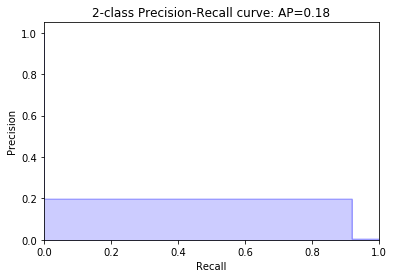

In [21]:
function.areaUnderPR(y_test, y_pred )

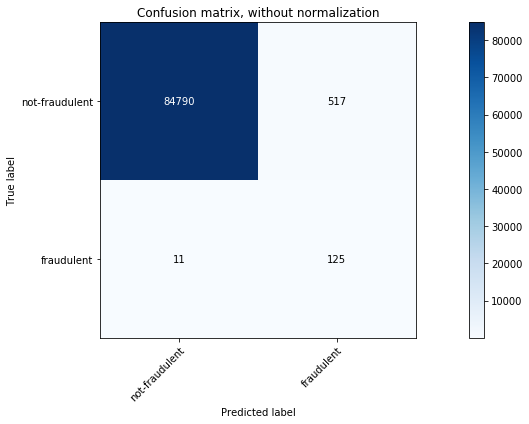

In [22]:
function.plot_confusion_matrix(y_true= y_test, y_pred= y_pred, classes= ["not-fraudulent", "fraudulent"])

# Over-sample

In [ ]:
%%time
X_train, y_train = function.smote_svm(X_train, y_train)

In [ ]:
1